In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from utils.matrix import project_points
from utils.colmap_data import COLMAP_Data
from utils.plot_utils import create_ellipsoids_as_one_mesh
from src.gaussian import GaussianSplatting
from utils.matrix import project_covariance
from matplotlib.collections import EllipseCollection

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
colmap_data = COLMAP_Data("data/sparse/0")
model = GaussianSplatting(colmap_data)
sigmas = model.init_gaussian_covariance()

e = colmap_data.W2C[colmap_data.frame_names[1]]
K = colmap_data.K
distortion = colmap_data.distortion
points = colmap_data.points

print(colmap_data.frame_names[1])
print(points.shape)

frame_00001.png
(56042, 3)


In [3]:
projected_points, projected_depths = project_points(points, e, K, return_depth=True)
bound_indices = (projected_points >= 0).all(axis=1) & \
    (projected_points < [colmap_data.width, colmap_data.height]).all(axis=1)

bounded_points = projected_points[bound_indices]
bounded_colors = colmap_data.colors[bound_indices]
bounded_depths = projected_depths[bound_indices]

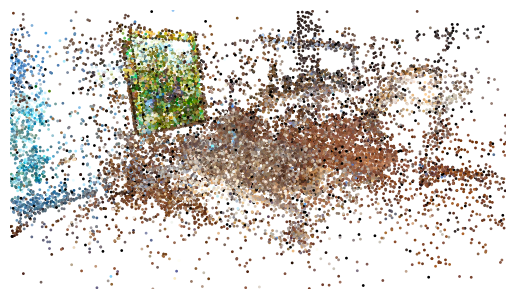

In [4]:
plt.scatter(bounded_points[:, 0], bounded_points[:, 1], c=bounded_colors, s=1)
plt.xlim(0, colmap_data.width)
plt.ylim(colmap_data.height, 0)  # Invert y-axis to match image coordinates
plt.gca().set_aspect('equal')
plt.axis('off')
plt.savefig('docs/images/projected_frame_00001.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [5]:
# Visualize covariance
viz_sigmas = sigmas * 0.1
big_mesh = create_ellipsoids_as_one_mesh(model.points, viz_sigmas, model.colors, sphere_resolution=10)
o3d.visualization.draw_geometries([big_mesh])

In [6]:
sigma_2d = project_covariance(points, sigmas, e, K)
bound_sigmas_2d = sigma_2d[bound_indices]

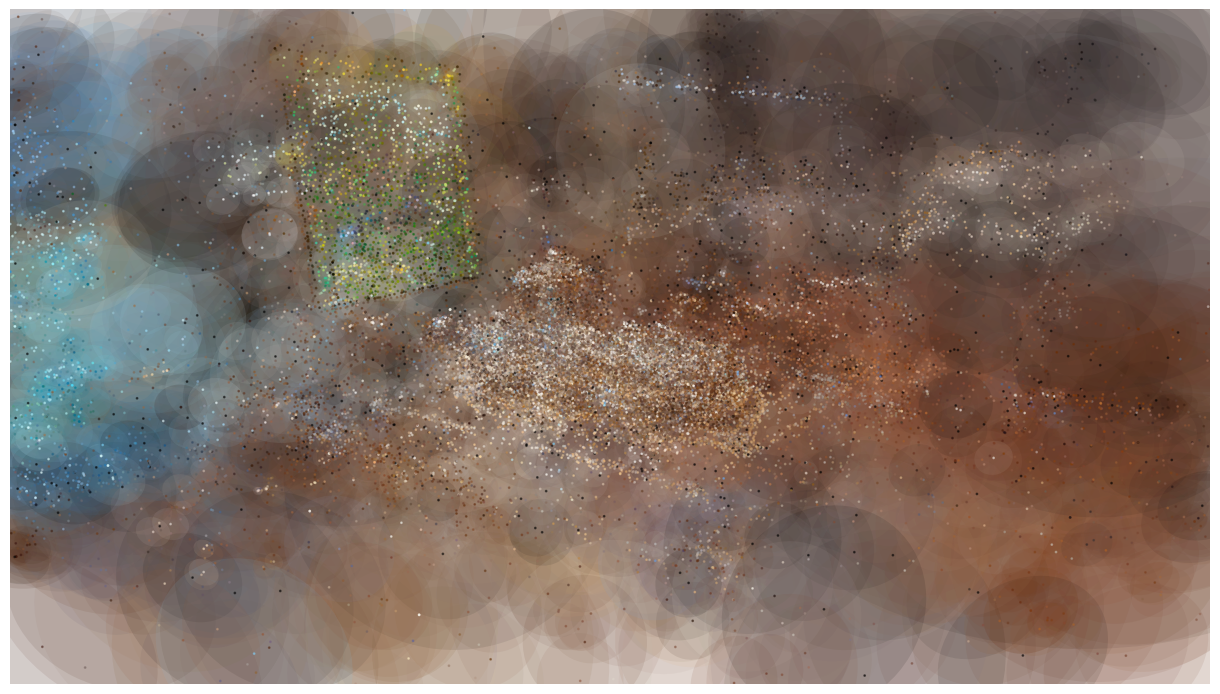

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

# for anisotropic covariance, modify this
eigenvals, eigenvecs = np.linalg.eigh(bound_sigmas_2d)

angles = np.degrees(np.arctan2(eigenvecs[:, 1, 0], eigenvecs[:, 0, 0]))
widths = 2 * np.sqrt(eigenvals[:, 0])
heights = 2 * np.sqrt(eigenvals[:, 1])

ec = EllipseCollection(
    widths, heights, angles,
    units='x',
    offsets=bounded_points,
    transOffset=ax.transData,
    facecolors=bounded_colors,
    alpha=0.1
)
ax.add_collection(ec)

ax.scatter(bounded_points[:, 0], bounded_points[:, 1], 
          c=bounded_colors, s=1, alpha=0.5)

ax.set_aspect('equal')
ax.set_xlim(0, colmap_data.width)
ax.set_ylim(colmap_data.height, 0)
ax.axis('off')
plt.gca().set_position([0, 0, 1, 1])
plt.savefig('docs/images/projected_gaussian_00001.png', 
            bbox_inches='tight',
            pad_inches=0)
plt.show()

In [ ]:
# To project covariance to image, apply differentiable tile rasterizer

"""
1. split screen into 16x16 pixel tiles.
2. cull gaussians
 - 99% confidence interval within bounds
 - extreme positions (near and far plane (?)) to avoid unstable 2D covariance
3. instantiate gaussian with hunber of tils they overlap (?)
4. assign each gaussian with key (view space depth, tile ID)
5. Radix sort with GPU (no per-pixel ordering)

6. Accumulate color and alpha from front to back until we reach target saturation (T_alpha)

"""

In [ ]:
img_name = colmap_data.frame_names[0]
img = plt.imread(f"data/images/{img_name}")
tile = img[:16, :16]
plt.imshow(tile)
plt.show()

In [25]:
# within view frustum, meaning within view frame

In [156]:
# project tile pixel space to 3D space to get view frustum bounds

tile_x1 = 0
tile_x2 = 960
tile_y1 = 0
tile_y2 = 540   
tile_pixels = np.array([[tile_x1, tile_y1], 
                        [tile_x2, tile_y1], 
                        [tile_x1, tile_y2], 
                        [tile_x2, tile_y2]])
tile_pixels = projected_points[0][np.newaxis]

def to_homogeneous(x):
    return np.hstack([x, np.ones((len(x), 1))])

tile_pixels_h = to_homogeneous(tile_pixels)
tile_pixels_cam = (tile_pixels_h @ np.linalg.inv(K).T)
tile_pixels_cam = tile_pixels_cam[:, :3] / tile_pixels_cam[:, 2:]

tile_pixels_world = to_homogeneous(tile_pixels_cam) @ np.linalg.inv(e).T
# tile_pixels_world = tile_pixels_world[:, :3] / tile_pixels_world[:, 2]

In [ ]:
tile_pixels_world

In [ ]:
points[0]

In [ ]:
# Gaussians with 99% confidence interval intersecting the view frustum
# so ensure 2 * scale *2.58 or 2* 2.58 * sqrt(diagonal(sigma)) is in view

